In [11]:
import pandas as pd
import torch.nn as nn
import torch

In [13]:
df_reviews = pd.read_csv("Amazon-Product-Reviews - Amazon Product Review(1).csv")[["review_body", "sentiment"]]
df_reviews = df_reviews.head(10000)
df_reviews

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
9995,quick and clear very happy,1
9996,Love It so Fun to Use The Books Are awesome,1
9997,Better than I expected! I have one that is a c...,1
9998,"so far, it has gone way beyond my expectations.",1


In [15]:
class Vocab:
    """ 用于存储单词的词典类 """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add(self, word):
        """ 添加单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)

    def __len__(self):
        """ 返回已存储的单词个数 """
        return len(self.idx2word)

In [17]:
class Embedding(nn.Module):
    def __init__(self, one_hot_size, vector_size):
        super().__init__()
        self.one_hot_size = one_hot_size
        self.fc = nn.Linear(one_hot_size, vector_size) # Fake embedding

    def forward(self, token_tensor):
        
        for token in token_tensor:
            init_one_hot = torch.zeros(1, self.one_hot_size)
            init_one_hot[0][token] = 1
            return self.fc(init_one_hot).squeeze()

In [85]:
reviews = df_reviews["review_body"]
reviews = reviews.dropna()
type(reviews)


filt = ["(", ")", "<", ">", ".", "...", ",", "!", "!!", "?", "/", "\\", "[", "]", "#", "&", "*" ] # ...
vocab = Vocab()
for word in list(reviews.values):
    word.replace("<br />", " ")
    lst = word.strip().split(" ")
    for single_word in lst:
        if single_word not in filt:
            vocab.add(single_word.strip()) 

In [28]:
class Word2Vec(nn.Module):
    """ 词向量模型 """
    def __init__(self, word_list, vector_size):
        super().__init__()
        self.word_list = word_list
        self.vector_size = vector_size
        self.embeddings = nn.Embedding(len(word_list), vector_size)
        self.fc = nn.Linear(vector_size, len(word_list))

    def forward(self, x):
        embedded = self.embeddings(x)
        return self.fc(embedded)

model = Word2Vec(vocab, 16)

In [29]:

def skipgram_data(words, window_size: int):
    """ 创建 Skip-Gram模型训练数据 """
    target_data = []
    context_data = []
    for i, target_word in enumerate(words):
        for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
            if j != i:
                context_word = words[j]
                target_data.append(vocab.word2idx.get(target_word))
                context_data.append(vocab.word2idx.get(context_word))
    return target_data, context_data
              
line = vocab.idx2word

In [87]:
len(line), line[9999: 10099]

(22448,
 ['$59',
  '8:15',
  'a.m.',
  'day).',
  'big,',
  'CHEAPER!',
  'overall,',
  'win-win.',
  'generations.',
  'source.',
  '&#34;Twilight&#34;',
  'filter',
  'UV',
  'harsh',
  'dimmer',
  'Kindle)',
  '(lots',
  'HBO',
  'series,',
  'movies)',
  'his,',
  'college.<br',
  'see-so',
  'dab',
  'nail',
  'polish',
  'raised',
  'issue.<br',
  'seamless',
  'members',
  'shipping,',
  'it)<br',
  'cool.<br',
  'travel;',
  'cheep',
  'BookBub',
  '&#60;info@bookbub.com&#62;',
  'blend',
  'streamlined.',
  'novice,',
  'complex',
  'experience.<br',
  'personalizing',
  'customizable',
  'root(a.k.a',
  'own...',
  'brick/break',
  'also)',
  'lockscreen,',
  'changeable.',
  'googling',
  'nearby..',
  '(sidenote:',
  'resolved)<br',
  '~$140',
  'wary',
  'Primeday',
  'worth..',
  'Mirrored',
  'stick(which',
  'love)but',
  "doesn't,",
  'it.My',
  'KIndle(2013)',
  '2?',
  'far...I',
  'Hardware',
  'HDTV',
  '-1',
  'that...',
  'prepared',
  'HAVE',
  'PURCHASED',
  'D

In [30]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

target_data, context_data = skipgram_data(line, 1)

dataset = TensorDataset(torch.tensor(target_data), torch.tensor(context_data))

dtloader = DataLoader(dataset, batch_size = 256, shuffle=True)

In [43]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 哞 """
    model.train()
    total_loss = 0
    for target, context in dataloader:
        context_hat = model(target)
        loss = loss_func(context_hat, context)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

In [45]:
model = Word2Vec(vocab, 16)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = dtloader

In [51]:
n_epoch = 100

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 9.5099
Epoch 2 loss: 9.3859
Epoch 3 loss: 9.263
Epoch 4 loss: 9.1401
Epoch 5 loss: 9.0175
Epoch 6 loss: 8.8941
Epoch 7 loss: 8.7714
Epoch 8 loss: 8.6477
Epoch 9 loss: 8.5243
Epoch 10 loss: 8.4013
Epoch 11 loss: 8.2775
Epoch 12 loss: 8.1547
Epoch 13 loss: 8.0316
Epoch 14 loss: 7.9093
Epoch 15 loss: 7.7873
Epoch 16 loss: 7.6662
Epoch 17 loss: 7.5451
Epoch 18 loss: 7.4253
Epoch 19 loss: 7.3066
Epoch 20 loss: 7.1888
Epoch 21 loss: 7.0723
Epoch 22 loss: 6.9564
Epoch 23 loss: 6.8425
Epoch 24 loss: 6.7292
Epoch 25 loss: 6.6168
Epoch 26 loss: 6.5065
Epoch 27 loss: 6.3975
Epoch 28 loss: 6.2889
Epoch 29 loss: 6.1819
Epoch 30 loss: 6.0773
Epoch 31 loss: 5.9733
Epoch 32 loss: 5.8702
Epoch 33 loss: 5.7692
Epoch 34 loss: 5.669
Epoch 35 loss: 5.5704
Epoch 36 loss: 5.4731
Epoch 37 loss: 5.376
Epoch 38 loss: 5.2815
Epoch 39 loss: 5.1874
Epoch 40 loss: 5.0943
Epoch 41 loss: 5.0048
Epoch 42 loss: 4.9145
Epoch 43 loss: 4.8267
Epoch 44 loss: 4.7386
Epoch 45 loss: 4.6534
Epoch 46 loss: 4.5681


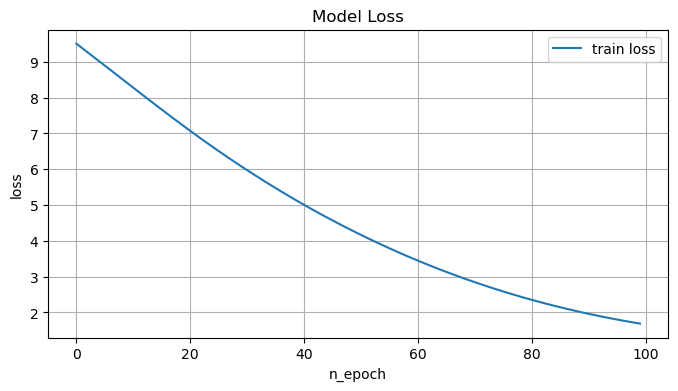

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.xlabel("n_epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()